# Item based kNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.sparse
import pickle
import glob

from surprise import Dataset, Reader, KNNBaseline, BaselineOnly, accuracy
from surprise.model_selection import GridSearchCV
from metrics import Evaluator

from time import perf_counter
from tqdm.notebook import tqdm

In [2]:
mypath = "/home/mmarzec12/data/"
savepath = "/home/mmarzec12/models/knn/model_tuning/"

In [7]:
explicit = pd.read_csv(mypath+"explicit_train.csv")
validation = pd.read_csv(mypath+"leave_one_out_validation.csv")

In [3]:
# list with (user,item) tuples from validation set
validation_list = [(u,i) for u,i in zip(validation.user_name, validation.game_id)]
# dict with user:game key-value pairs from validation set
validation_dict = {u:i for u,i in zip(validation.user_name, validation.game_id)}

# unique series for users and games
users = explicit.user_name.unique()
games = explicit.game_id.unique()

In [4]:
# reading data from a file
# reader = Reader(skip_lines=1, sep=",", rating_scale=(1,10))
# data = Dataset.load_from_file(mypath+"explicit_train.csv", reader=reader)


# reading data from pandas dataframe
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(explicit, reader)

# using whole df as trainset
trainset = data.build_full_trainset()

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


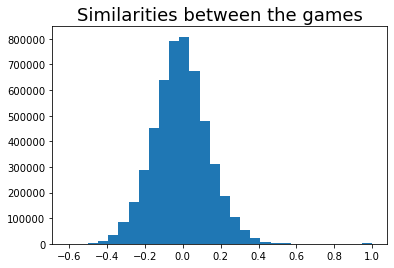

In [5]:
# configurins learning options

# similarity part of the model configuration
# name - similarity measure
# user_based - if false user based similarity matrix is calculated
# min_support - minimal number of similar items
# shrunkage - paramter from shrunk Pearson correlation coefficient
# ref: https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration
sim_options = {"name": "pearson_baseline",
              "user_based": False,
              "min_support": 1,
              "shrinkage": 10}

# baseline part of the model configuration
bsl_options = {"method": "sgd",
              "learning_rate": 0.01,
              "reg":0.02,
              "n_epochs":20}


knn = KNNBaseline(k=30, min_k=2, 
                  sim_options=sim_options, 
                  bsl_options=bsl_options)

# training
knn.fit(trainset)

# plotting similarities
plt.hist(knn.sim.ravel(), bins=30)
plt.title("Similarities between the games", fontsize=18)
plt.show()

# we won't be using sim <0
knn.sim[knn.sim<0] = 0

In [ ]:
# validation 
# val_set = trainset.build_anti_testset()
# start = perf_counter()
# predictions = knn.test(val_set)
# elapsed = perf_counter() - start
# print(f"Calculating all the ratings took {round(elapsed, 2)/60} minutes.")

## Hyperparameter tuning

We want to tune $\lambda$, which shrunks  the pearson correlation coefficint as well as $k$ - the size of neighborhood. The settings for tuning parameters of baseline model ($b_{ui}$ part) were already tuned.

In [10]:
# shrunking coefficient
lambdas = [10, 30, 100]
# neighborhood size
negihborhood_sizes = [10, 20, 30, 40]
# top-10 recommendation list
k = 10 
# sample size 
sample_size = 200
# min_k from knn (surprise docs for more info)
min_k_knn = 2


# setting initial options for model training
# similarity part of the model configuration
sim_options = {"name": "pearson_baseline",
              "user_based": False,
              "min_support": 1,
              "shrinkage": 10}
# baseline part of the model configuration
bsl_options = {"method": "sgd",
              "learning_rate": 0.01,
              "reg":0.02,
              "n_epochs":20}

counter = 1
for lambda_ in lambdas:
    for neigh_size in negihborhood_sizes:
        print(f"Model number {counter} is being trained.")
        # set the parameters
        sim_options["shrinkage"] = lambda_
        
        # train the model
        knn = KNNBaseline(k=neigh_size, min_k=min_k_knn, 
                  sim_options=sim_options, 
                  bsl_options=bsl_options)
        
        knn.fit(trainset)
        knn.sim[knn.sim<0] = 0
        
        print("Computing top-k list for each user...")
        # produce top k list for all users
        top_k_list = produce_top_k(model=knn, users=users, games=games,
                                   validation_dict=validation_dict,
                                   k=k, sample_size=sample_size)
        
        
        print("...evaluation...")
        ev = Evaluator(k=k, true=validation_list, predicted=top_k_list)
        ev.calculate_metrics()
        ngcg10, err10, hr10 = ev.ndcg, ev.err, ev.hr
        
        # save the obtained results
        res = {}
        res["shrunking_coef"] = lambda_
        res["neighborhood_size"] = neigh_size
        res["k"] = k
        res["ndcg10"] = ngcg10
        res["err10"] = err10
        res["hr10"] = hr10
        res["sample_size"] = sample_size
        res["sim_options"] = sim_options
        res["bsl_options"] = bsl_options
        res["min_k_knn"] = min_k_knn
        
        # save the obtained results
        with open(savepath+f"knn_{counter}", "wb") as handle:
            pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        counter += 1
        print("...and end.")

Model number 1 is being trained.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing top-k list for each user...


  0%|          | 0/109084 [00:00<?, ?it/s]

...evaluation...
...end.
Model number 2 is being trained.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...


KeyboardInterrupt: 

## Results

In [3]:
n_files = len(glob.glob(savepath+"/*"))
res = []
for i in range(1,n_files+1):
    res.append(pd.read_pickle(savepath+f"/knn_{i}"))

In [4]:
resdf = pd.DataFrame(columns=["shrunking_coef", "neighborhood_size", "metric_name", "metric_value"])
rows_list = []
for r in res:
    d1 = {}
    d1["shrunking_coef"] = r["shrunking_coef"]
    d1["neighborhood_size"] = r["neighborhood_size"]
    d1["metric_name"] = "NDCG10"
    d1["metric_value"] = r["ndcg"]
    rows_list.append(d1)
    
    d2 = {}
    d2["shrunking_coef"] = r["shrunking_coef"]
    d2["neighborhood_size"] = r["neighborhood_size"]
    d2["metric_name"] = "ERR10"
    d2["metric_value"] = r["err"]
    rows_list.append(d2)
    
    d3 = {}
    d3["shrunking_coef"] = r["shrunking_coef"]
    d3["neighborhood_size"] = r["neighborhood_size"]
    d3["metric_name"] = "HR10"
    d3["metric_value"] = r["hr10"]
    rows_list.append(d3)

    
resdf = pd.DataFrame(rows_list)

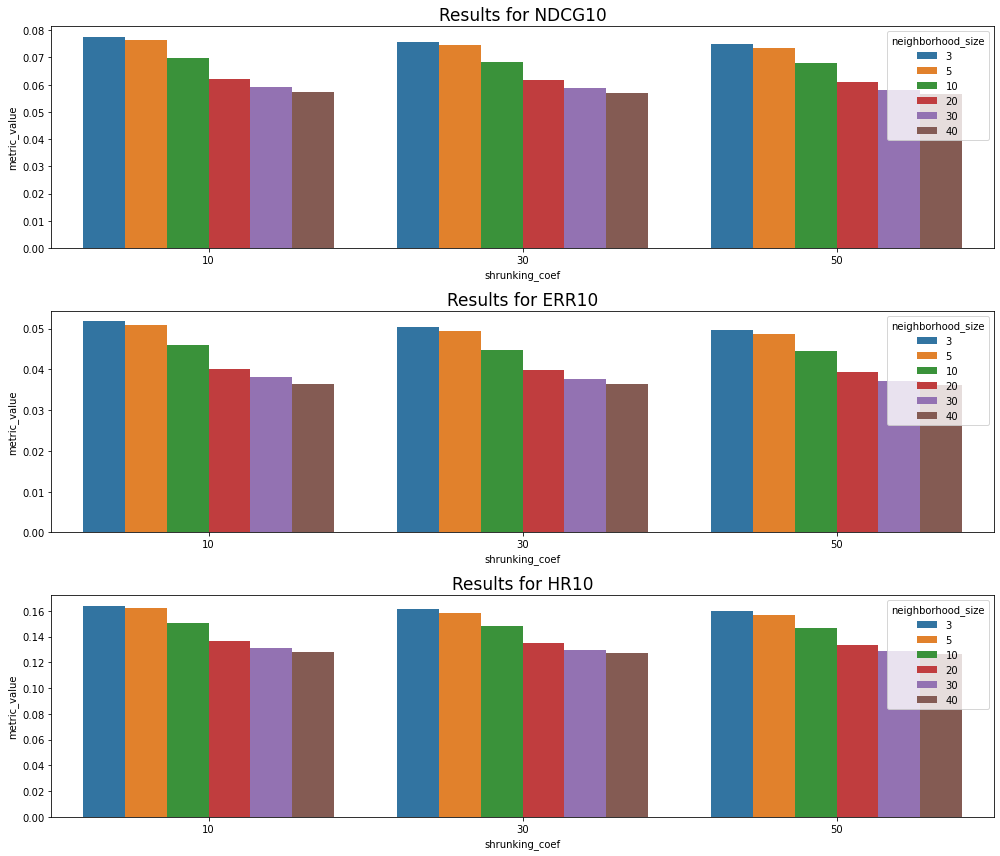

In [6]:
metrics = resdf.metric_name.unique()
fig, axes = plt.subplots(3, 1, figsize=(14,12))
for i in range(len(metrics)):
    tmp = resdf[resdf.metric_name==metrics[i]]
    axes[i].set_title(f"Results for {metrics[i]}", fontsize=17)
    sn.barplot(y="metric_value", x="shrunking_coef", hue="neighborhood_size", data=tmp, ax=axes[i])
    
plt.tight_layout()

In [29]:
resdf[resdf.neighborhood_size==10]

,shrunking_coef,neighborhood_size,metric_name,metric_value
3,10,10,NDCG10,0.053850
4,10,10,ERR10,0.034207
5,10,10,HR10,0.120173
18,30,10,NDCG10,0.052242
19,30,10,ERR10,0.033155
20,30,10,HR10,0.116782
33,100,10,NDCG10,0.049778
34,100,10,ERR10,0.031208
35,100,10,HR10,0.112592


In [45]:
#row = explicit.user_name
#col = explicit.game_id
#data = explicit.score
#X = scipy.sparse.coo_matrix(data, (row,col))

0.3932052957506905 0.24300058400099736 0.9026043819760231


In [ ]:
ev = 

In [65]:
# validation methodology:



preds_top_10 = {}
j = 0
start = perf_counter()
for user_id in tqdm(users):
    user_preds = []
    # getting ratings for specific user
    for game in games:
        game_id = game
        r_hat = knn.predict(user_id, game_id).est
        user_preds.append((r_hat,game_id))
    
    # selecting only top 10 ratings
    user_preds.sort(key=lambda x: x[1], reverse=True)
    # selecting only game ids
    user_preds = [i[1] for i in user_preds[:10]]
    
    # addending results to the dict
    preds_top_10[user_id] = user_preds
    
    # timing the results
    j += 1
    if j % 500 == 0:
        print(f"We have preprocessed results for {j} users already, that took {round(perf_counter() - start,2)/60} minutes.")
        start = perf_counter()
        break


  0%|          | 0/109084 [00:00<?, ?it/s]

We have preprocessed results for 500 users already, that took 2.6008333333333336 minutes.


In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        top_n[uid] = [i[0] for i in top_n[uid]]

    return top_n

In [ ]:
ngcg10, err10, hr10

In [6]:
# need to be improved if I want it to
# be faster than python sort

def select_top_n(l, n):
    res = []
    lcopy = l.copy()
    for _ in range(n):
            max_ = (0,0)
            for i in lcopy:
                if i[0] > max_[0]:
                    max_ = i
            
            res.append(max_)
            lcopy.remove(max_)
    
    return res

In [30]:
a = list(preds_top_10.keys())
val = validation
val.index = val.user_name
val_subset = val.loc[a,]
true = [(u,i) for u,i in zip(val_subset.user_name, val_subset.game_id)]

In [ ]:
users = explicit.user_name.unique()
games = explicit.game_id.unique()

preds_top_10 = {}
j = 0
total = perf_counter()
start = perf_counter()
for user_id in users:
    user_preds = []
    
    # getting ratings for specific user
    for game in games:
        game_id = game
        r_hat = knn.predict(user_id, game_id).est
        user_preds.append((r_hat,game_id))
    
    # selecting only top 10 ratings
    user_preds.sort(key=lambda x: x[1], reverse=True)
    # selecting only game ids
    user_preds = [i[1] for i in user_preds[:10]]
    
    # addending results to the dict
    preds_top_10[user_id] = user_preds
    
    # timing the results
    j += 1
    if j % 500 == 0:
        print(f"We have preprocessed results for {j} users already, that took {round(perf_counter() - start,2)/60} minutes.")
        start = perf_counter()
        break

In [ ]:
# list with tuples from validation set
true = [(u,i) for u,i in zip(validation.user_name, validation.game_id)]

#

# Evaluator class for getting NDCG@K, ERR@K, HR@K
ev = Evaluator(k=10, true=true, predicted=preds_top_10)
ev.calculate_metrics()
ngcg10, err10, hr10 = ev.ndcg, ev.err, ev.hr

In [35]:
ngcg10, err10, hr10

(0.47339964710175053, 0.326140873015873, 0.9583333333333334)

In [32]:
import numpy as np
class Evaluator:
    """
    Description:
    -----------
    
    A class for making leave-one-out valiadation.
    It computes NDCG@k, HR@k, and ERR@k.
    
    Assumptions: the only one item that is present for
    each user has relevane=1 all remaining have relevance=0
    
    
    Parameters:
    ----------
    
    true - list of tuples with (user_id, item_id), these are 
    the items which we want to see at the top of recommendation list
    
    predicted - dict with users and their recommendations
    in form: {user_id:[top_k_recommendation_list]}, where the top_k_list
    contains item_ids
    
    k - to calculate measures @k
    """
    
    def __init__(self, k, true, predicted):
        self.k = k
        self.ndcg = 0
        self.hr = 0
        self.err = 0
        self.true = true
        self.predicted = predicted
    
    
    def calculate_metrics(self):
        hrs = []
        errs = []
        ndcgs = []
        
        # denominators for NDCG
        denoms = 1. / np.log2(np.arange(2, self.k + 2))

        # ideal DCG
        IDCG = denoms[0]

        for uid,iid in self.true:
            pos = 0
            for item_id in self.predicted[uid]:
                if item_id==iid:
                    hrs.append(1)
                    errs.append(1/(pos+1))
                    ndcgs.append(denoms[pos] / IDCG)
                    break
                else:
                    pos += 1

            # if item from test set is not in top-k list
            if pos == self.k-1:
                hrs.append(0)
                errs.append(0)
                ndcgs.append(0)
        
        self.ndcg = np.mean(ndcgs)
        self.hr = np.mean(hrs)
        self.err = np.mean(errs)

    
    
    

In [ ]:
ev = Evaluator()

In [28]:
explicit[explicit.user_name=="hsjx945"].shape

(154, 3)

In [52]:
uid = "hsjx945" # user id, as string
iid = str(172)  # item id, as string

# get a prediction for specific users and items.
pred = knn.predict(uid, iid, verbose=True)

user: hsjx945    item: 172        r_ui = None   est = 7.01   {'was_impossible': False}


In [69]:
res = []
for game_id in explicit.game_id.unique():
    res.append(knn.predict("hsjx945", game_id).est)

In [30]:
explicit

,user_name,game_id,score
0,hsjx945,1,8.0
1,hsjx945,3,7.3
2,hsjx945,11,6.8
3,hsjx945,12,6.5
4,hsjx945,172,6.0
...,...,...,...
5861075,CRTMN0463,223362,10.0
5861076,CRTMN0463,193513,10.0
5861077,CRTMN0463,156689,10.0
5861078,CRTMN0463,175156,10.0
